<a href="https://colab.research.google.com/github/JVTh/School/blob/main/NLP_JonVidir_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Natural Language Processing on Public Sentiment on Education

Analysing the sentiment in online discourse on education

Jón Víðir Þorvaldsson

In this report, I will analyse the sentiment and topics that arise in online discussions on education. Education is a subject of paramount importance, and online discussions provide an insightful lens to look into these discussions. Computational analysis makes it possible to uncover the sentiments expressed by the public and gain insights on the perception and opinions about education. All of which can prove useful in policy making and further research.

This has been done to conduct research on public sentiment on education, notably by Özyurs & Kisa (2021) who researched sentiments toward distance education during Covid-19 among twitter users. These methods provide researchers the tools to gain deeper insights into public sentiments on topics such as education (Kedia & Rasu, 2020).

Data was gathered using the Reddit Pushsift API to collect comments from the subreddit Education, dated from the month of January 2024. To analyse this large amount of data, Natural Language Processing is used to expand the capacity for analyzing a large volume of textual data.


In [ ]:
# Importing required packages
import pandas as pd
import spacy
from transformers import pipeline, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [ ]:
!gdown https://drive.google.com/uc?id=1G9-4_whd8BCObf3Gp6HDFFpQbDt_eTvy
# Downloading the dataset and displaying the first 5 rows of the dataframe
df = pd.read_excel("education24.xlsx", header=None, names=['id', 'text'])
print(df.head())


Downloading...
From: https://drive.google.com/uc?id=1G9-4_whd8BCObf3Gp6HDFFpQbDt_eTvy
To: /content/education24.xlsx
100% 302k/302k [00:00<00:00, 75.0MB/s]
   id                                               text
0   0  Have you spoken with the teacher to clarify th...
1   1  Students are supposed to watch the assigned vi...
2   2  So, let me get this straight, you_x0019_re pre...
3   3   I HIGHLY doubt that happened. It could have b...
4   4  Bad. Faster students slowed down so slow stude...


The initial phase of the analysis is data pre-processing, a crucial step in preparing the data for analysis. SpaCy library allows for tokenization and lemmatization that dissects the text into it's constituent components and standardizes the text by reducing it to it's base form. I also remove stopwords, punctuations and non-alphabetic characters with the aim to enhance the quality and coherence of the text data for further analysis.

In [ ]:
!python -m spacy download en_core_web_sm
# Loading the English language model for spaCy
nlp = spacy.load('en_core_web_sm')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha])
# Preprocessing the 'text' column using spaCy for lemmatization and stop word removal

df['processed_text'] = df['text'].apply(preprocess_text)
print(df.head())


   id                                               text  \
0   0  Have you spoken with the teacher to clarify th...   
1   1  Students are supposed to watch the assigned vi...   
2   2  So, let me get this straight, you_x0019_re pre...   
3   3   I HIGHLY doubt that happened. It could have b...   
4   4  Bad. Faster students slowed down so slow stude...   

                                      processed_text  
0  speak teacher clarify expectation sound like s...  
1  student suppose watch assign video read assign...  
2  let straight preemptively build case likely wa...  
3  highly doubt happen student teacher comment yo...  
4  bad fast student slow slow student basically i...  


In [ ]:
# Comparing the original text and processed text
print("Original Text: ", df.loc[0, 'text'])
print("Processed Text: ", df.loc[0, 'processed_text'])


Original Text:  Have you spoken with the teacher to clarify the expectations? It sounds like you spoke with other parents, searched on Google etc. but you don_x0019_t mention having a conversation with the teacher.
Processed Text:  speak teacher clarify expectation sound like speak parent search google etc mention have conversation teacher


## Sentiment analysis


Sentiment analysis both allows for the discernation of the emotional tone and polarity of the data. I employ the sentiment analysis tool transformers by Huggingface (2024), which is well-equipped to evaluate the sentiment of each comment, providing sentiment labels, positive or negative (-1 or 1).

In [ ]:
# Initializing the sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")


In [ ]:
!pip install transformers
from transformers import pipeline

# Loading the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
from transformers import AutoTokenizer

# Loading the tokenizer corresponding to the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

def truncate_text_with_tokenizer(text, max_length=512):
    # Tokenizing the text and truncate to the max_length
    tokens = tokenizer.encode(text, max_length=max_length, truncation=True, return_tensors="pt")
    # Decoding back to a string, ignoring special tokens
    truncated_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
    return truncated_text

# Applying this new truncation function
df['truncated_text'] = df['text'].apply(lambda x: truncate_text_with_tokenizer(x))



In [ ]:
# Reapplying sentiment analysis with the correctly truncated text
df['sentiment'] = df['truncated_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
df['sentiment_score'] = df['truncated_text'].apply(lambda x: sentiment_pipeline(x)[0]['score'])

print(df[['text', 'sentiment', 'sentiment_score']].head())



                                                text sentiment  \
0  Have you spoken with the teacher to clarify th...  NEGATIVE   
1  Students are supposed to watch the assigned vi...  NEGATIVE   
2  So, let me get this straight, you_x0019_re pre...  NEGATIVE   
3   I HIGHLY doubt that happened. It could have b...  NEGATIVE   
4  Bad. Faster students slowed down so slow stude...  NEGATIVE   

   sentiment_score  
0         0.968895  
1         0.998758  
2         0.998304  
3         0.995764  
4         0.999697  


In [ ]:
print(df[['text', 'sentiment']].head())


                                                text sentiment
0  Have you spoken with the teacher to clarify th...  NEGATIVE
1  Students are supposed to watch the assigned vi...  NEGATIVE
2  So, let me get this straight, you_x0019_re pre...  NEGATIVE
3   I HIGHLY doubt that happened. It could have b...  NEGATIVE
4  Bad. Faster students slowed down so slow stude...  NEGATIVE


# **Visualization of sentiment**

To visually capture the distribution of sentiments in the data, I use the seaborn and matplotlib libraries to present an overview of the sentiment in the data. As we can see, the sentiment is rather negative in the dataset as a whole.

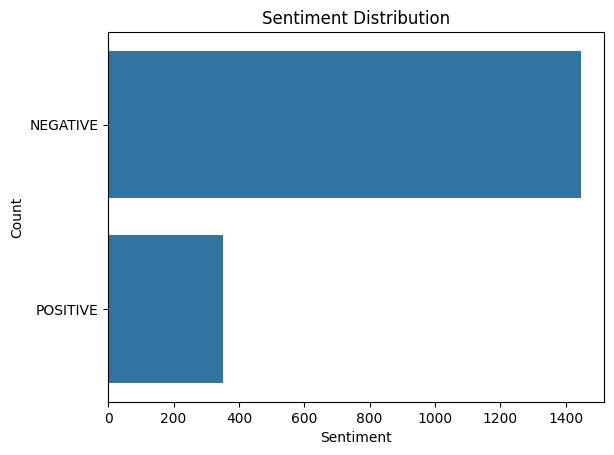

In [ ]:
# Visualizing the distribution of sentiment labels using a countplot
sns.countplot(df['sentiment'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


To offer a more intuitive representation of the most frequently occuring terms in both positive and negative sentiments, I use word clouds. These capture glimpses into the prominent words associated with each sentiment category. As we can see, the words most discussed in both categories are rather similar. Allowing for the inference that the comments are in general discussing similar things regardless if the comment is negative or positive.

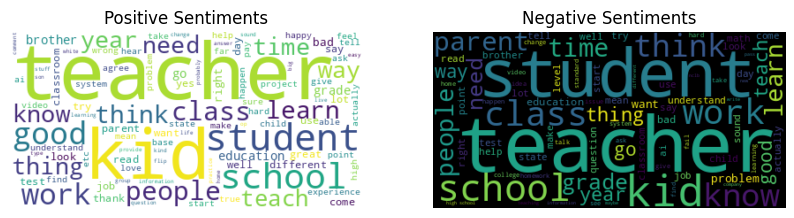

In [ ]:
from wordcloud import WordCloud

# Generating a word cloud for positive sentiments
positive_text = ' '.join(df[df['sentiment'] == 'POSITIVE']['processed_text'])
positive_wordcloud = WordCloud(background_color='white', max_words=100).generate(positive_text)

# Generating a word cloud for negative sentiments
negative_text = ' '.join(df[df['sentiment'] == 'NEGATIVE']['processed_text'])
negative_wordcloud = WordCloud(background_color='black', max_words=100).generate(negative_text)

# Displaying the word clouds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiments')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiments')
plt.axis('off')

plt.show()


# **Topic modeling**

Topic modeling is a pivotal aspect of the analysis. This enables for the identification of the key subjects being discussed in the data, allowing for a better understanding of the discussions on education. It would also have been appropriate to conduct the topic modeling before the sentiment analysis, but since we started on analysing the sentiment, we can now look into if there are multiple topics being discussed in the comments and if the different topics are in general more positive or negative.

In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Lets look at the coherence scores for different numbers of topics generated by the topic modeling algorythm. the coherence score is a measure of how smantically similar the high-scoring words are in each topic, indicating the queality of the topics generated. Higher coherence scores suggest that the topics are more interpretable and meaningful. As seen on the graph, the highest coherence score is 1 topic, but for the sake of this assignment lets continue with 2 topics and see if we can identify a difference.

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Tokenizing the processed text
df['tokenized_text'] = df['processed_text'].apply(lambda x: simple_preprocess(x, deacc=True))

# Creating a dictionary representation of the documents
id2word = Dictionary(df['tokenized_text'])

id2word.filter_extremes(no_below=5, no_above=0.5)

corpus = [id2word.doc2bow(text) for text in df['tokenized_text']]


In [ ]:
# Defining the range of topics to explore
topics = range(1, 20)

coherence_scores = []

for num_topics in topics:
    # Applying LDA model for each number of topics
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, iterations=10, passes=10, random_state=100)
    # Calculating and append coherence score
    cm = CoherenceModel(model=lda_model, texts=df['tokenized_text'].tolist(), dictionary=id2word, coherence='c_v')
    coherence_scores.append(cm.get_coherence())


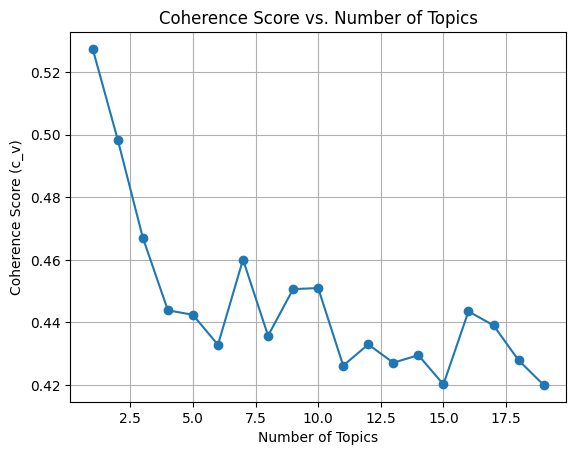

In [ ]:
import matplotlib.pyplot as plt

plt.plot(topics, coherence_scores, marker='o', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word',
                             min_df=10,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000,
                            )

# Using CountVectorizer to transform the preprocessed text
data_vectorized = vectorizer.fit_transform(df['processed_text'])

# Fitting the LDA Model
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_Z = lda_model.fit_transform(data_vectorized)

print(f"Shape of document-topic matrix: {lda_Z.shape}")


Shape of document-topic matrix: (1798, 4)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_Z = lda_model.fit_transform(data_vectorized)

print(f"Shape of document-topic matrix: {lda_Z.shape}")


Shape of document-topic matrix: (1798, 2)


The top 10 words for each topic, as we can see there are a lot of similarities between the topics, though we can see some unique words pop up in each topic that do not show up as top 10 words in the other. Taking those into account, I will name each topic according to their unique words.

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda_model, vectorizer.get_feature_names_out(), n_top_words=10)


Topic #1:
teacher people like think know brother thing good kid want
Topic #2:
school student teacher kid class work grade learn year parent



In [ ]:
# Manually defined topic names based on the main words and discussion
topic_names = {
    0: 'Personal and reflective views on education',
    1: 'Academic environment and engagement'
}


To visualize this even further, here is a plot of the word frequency for each topic.

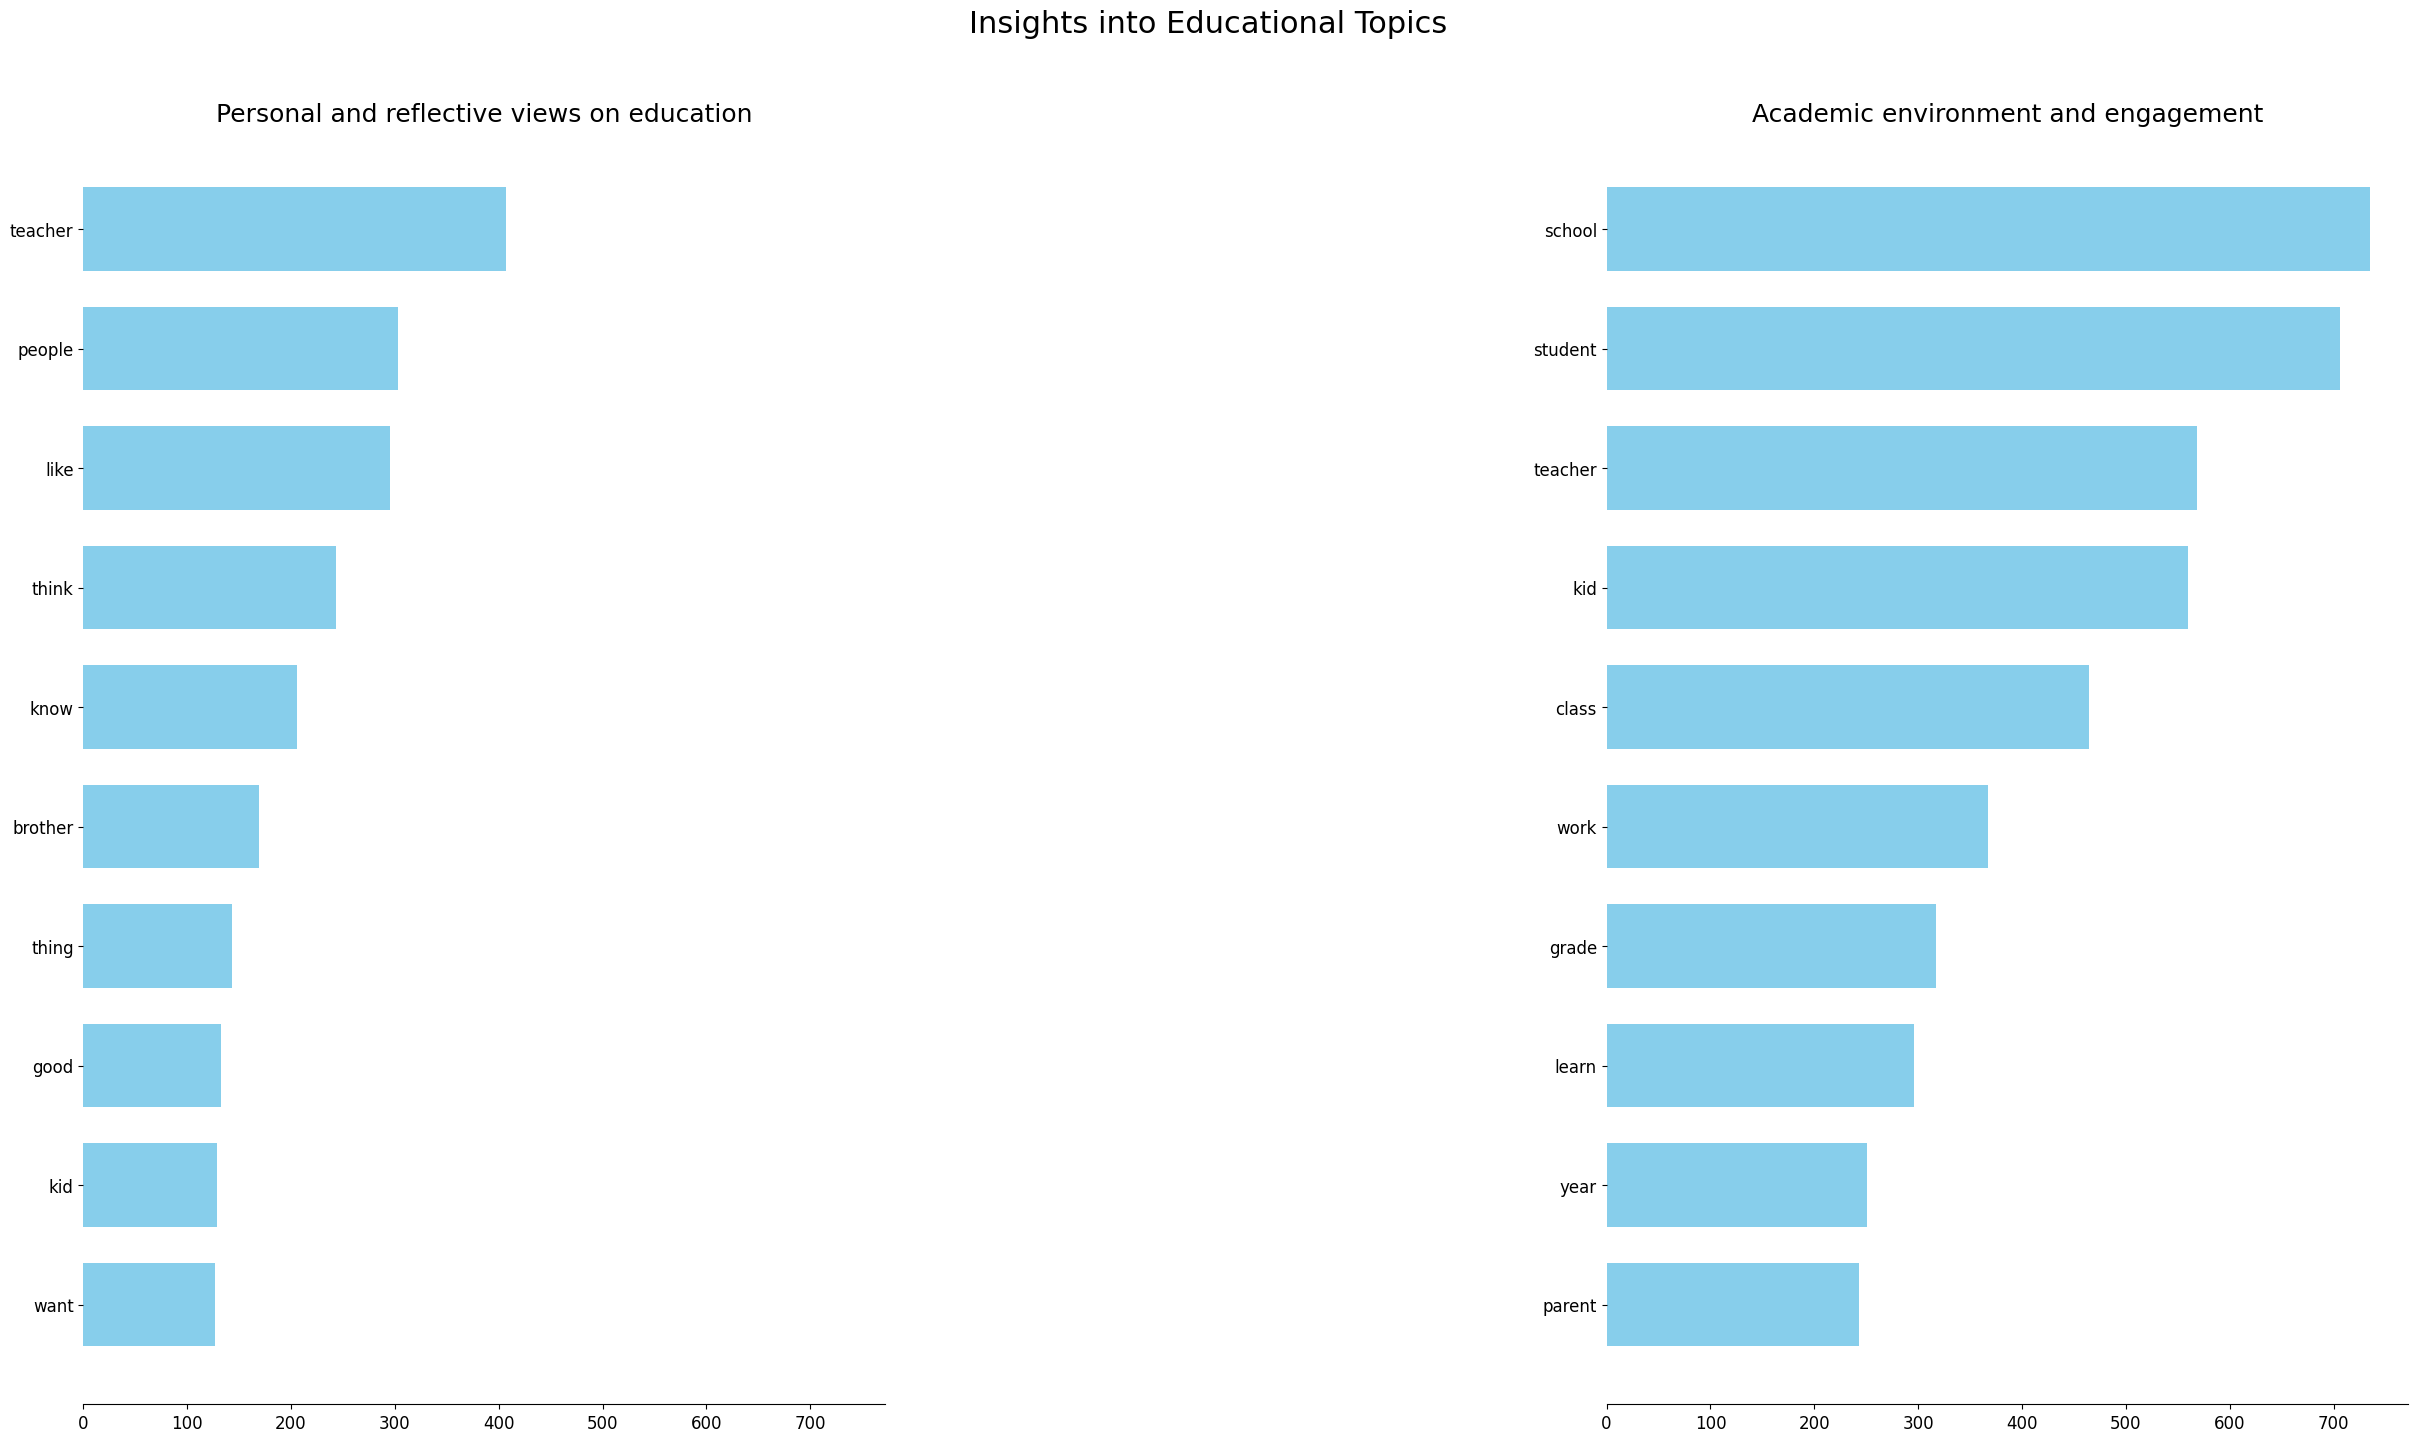

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_words_with_names(model, feature_names, n_top_words, topic_names, title):
    fig, axes = plt.subplots(1, len(topic_names), figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='skyblue')
        # Using topic names for titles
        ax.set_title(f'{topic_names[topic_idx]}', fontdict={'fontsize': 18})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle(title, fontsize=22)
    plt.show()

plot_top_words_with_names(lda_model, vectorizer.get_feature_names_out(), 10, topic_names, 'Insights into Educational Topics')


In [ ]:
dominant_topic = np.argmax(lda_Z, axis=1)
df['topic'] = dominant_topic


In [ ]:
# Mapping numeric topics to descriptive names
df['topic_name'] = df['topic'].map(topic_names)

# Displaying the DataFrame to verify the mapping
print(df[['topic', 'topic_name']].head())


   topic                                  topic_name
0      0  Personal and reflective views on education
1      1         Academic environment and engagement
2      0  Personal and reflective views on education
3      0  Personal and reflective views on education
4      1         Academic environment and engagement


In [ ]:
# Mapping numeric dominant topics to descriptive names
df['topic_name'] = df['topic'].map(topic_names)

print(df[['topic', 'topic_name']].head())


   topic                                  topic_name
0      0  Personal and reflective views on education
1      1         Academic environment and engagement
2      0  Personal and reflective views on education
3      0  Personal and reflective views on education
4      1         Academic environment and engagement


In [ ]:
df['dominant_topic_name'] = df['topic'].map(topic_names)

# **Distribution of sentiment**

Here we can see the distribution of sentiment between the topics. As we can see, they are both dominantly negative and the ratio between positive and negative seems to be similar for both topics.

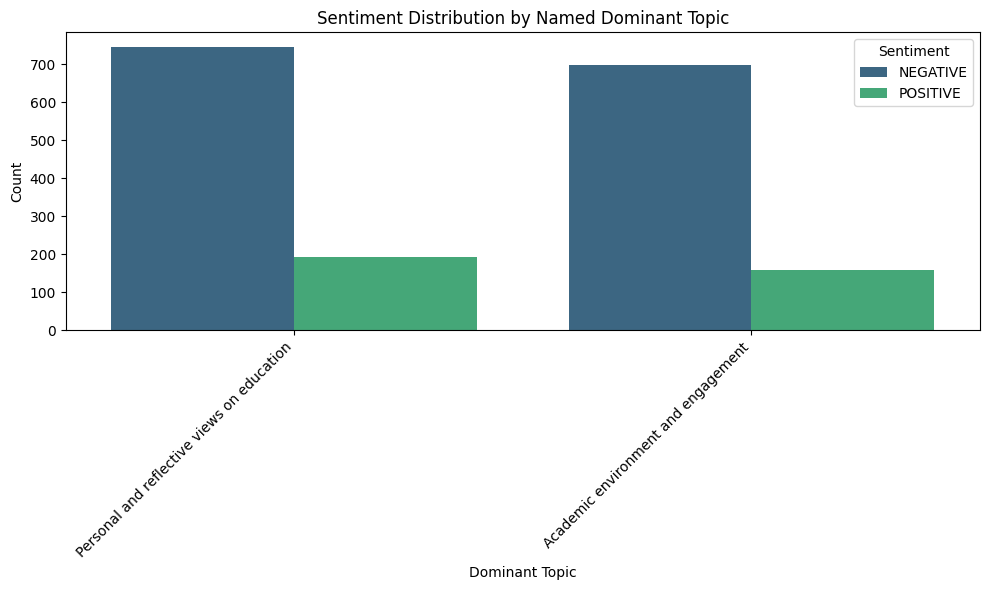

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='dominant_topic_name', hue='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution by Named Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()



Here we can see the distribution of document lenght by sentiment. The negative documents have more variety in lenght compared to the positive ones. It is worth mentioning here that there were a lot fewer positive documents compared to negative ones, but it is still safe to say negative documents are in general longer.

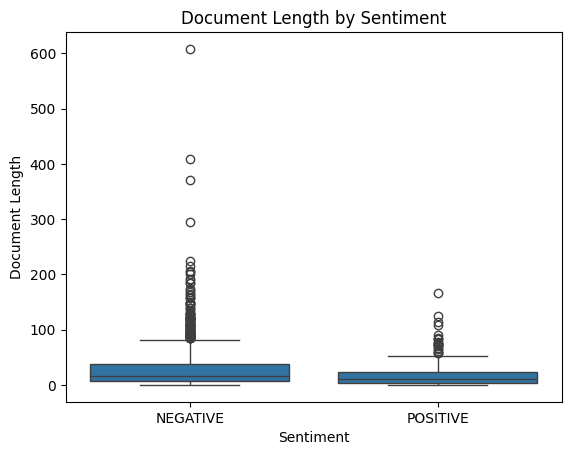

In [ ]:
df['doc_length'] = df['processed_text'].apply(lambda x: len(x.split()))

# Visualizing document length by sentiment
sns.boxplot(x='sentiment', y='doc_length', data=df)
plt.title('Document Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Document Length')
plt.show()


# **Results**

The results underscore the complex dynamics of online discourse, particularly on platforms like Reddit. The analysis revealed a general trend towards negativity, which could reflect broader societal sentiments or specific communities' cultures on Reddit. The document length's role in sentiment classification further complicates the narrative, introducing questions about the nature of online expression and its interpretation by machine learning models such as Huggingface's transformers package. The coherence score, while guiding the thematic analysis, indicated a preference for a singular, overarching theme. However, the decision to explore two distinct cases showcased the opportunity to research a nuanced understanding of the dataset, despite the similar outcomes across these categories. This decision highlights the trade-off between thematic breadth and analytical depth in sentiment analysis projects.



# **Discussions**

The sentiment analysis conducted on the online discussions from Reddit revealed a predominance of negative sentiment across the dataset. Regarding the correlation between longer texts being more negative, it suggests that when individuals have more space to articulate their thoughts, they might delve into more detailed critiques or express dissatisfaction more thoroughly, contributing to the overall negative sentiment. Alternatively, it could indicate a potential bias in the machine learning model used for sentiment analysis, where longer texts are disproportionately classified as negative. This bias could stem from the training data or inherent model characteristics that associate verbosity with negativity or the simple fact that a text with more words has more opportunities to be classified as negative.

Looking ahead, several avenues for further research present themselves. Expanding the dataset to include discussions from different time periods could offer insights into how online sentiments evolve in response to global events, such as the Covid-19 pandemic. Such an analysis could shed light on how external events influence our perception of stable things in our lives, such as education, and also how the internet works as a reflection of societal mood and public discourse trends over time.

Moreover, cross-platform comparisons, including discussions from other social media sites, could contextualize the findings from Reddit within the broader landscape of online discourse. This comparative approach could reveal platform-specific dynamics and the influence of platform design on user behavior and sentiment expression.

Research such as this holds profound relevance for policymakers and governments seeking to enhance their education systems, as it offers a nuanced understanding of public sentiment and discourse around education, thereby informing more empathetic and effective policy-making that resonates with the concerns and aspirations of the community.












## **References**

Huggingface (2022) 🤗 Transformers. Available at: https://huggingface.co/docs/transformers/index (Accessed: 12. 01. 2024).

Kedia, A. & Rasu, M. (2020) Hands-On Python Natural Explore tools and techniques to analyze and process text with. Packt Publishing, Ltd.

ÖZYURT, Ö., & KISA, N. (2021). Sentiment analysis of tweets relating to distance education during the COVID-19 pandemic. Journal of Computer and Education Research, 9(18), 853–868. https://doi.org/10.18009/jcer.950790